In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch.nn import functional as F
import scipy.stats
import sklearn.datasets

import sys
sys.path.append("../")
import curvvae_lib.train.predictive_passthrough_trainer as ppttrainer
import curvvae_lib.architecture.passthrough_vae as ptvae
import curvvae_lib.architecture.save_model as sm
import curvvae_lib.architecture.load_model as lm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-umxo3mqj because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Dataset

In [2]:
foodname = "banana"
foldername = f"fork_trajectory_{foodname}"
savefilename = f"{foodname}_clean_pickups"

In [3]:
train = []
training_ts = np.linspace(0,1,64)
attempt = 1
while True:
    try:
        raw_vals = np.load(f"{savefilename}/pickup_attempt{attempt}.npy")
        train.append(raw_vals.T.flatten())
    except:
        print(f"We found {attempt-1} pickup attempts")
        break
    attempt += 1

train = np.array(train).reshape(-1,7,64)
all_points = train[:,:,:]

time_shape = list(all_points.shape)
time_shape[1] = 1
# why be smart when you can be dumb
t = np.ones(time_shape)
for i in range(time_shape[2]):
    t[:,:,i] = t[:,:,i] * i / (time_shape[2] + 0.0)

all_points = np.concatenate((t, all_points), axis=1)
all_points = all_points.transpose(0,2,1)
# actually this is all points, not just start points
start_points = all_points[:,:,1:].reshape(-1,7)
print("start_points_shape", start_points.shape)
# See http://localhost:8889/notebooks/scratchwork/2021-09-17%20Rotation%20Scaling.ipynb
# for why we want quaternion values to be multiplied by 0.16 when position values are in meters 
# (if the relevant distance scale of the fork is 0.08 meters, ie: 8cm).
mean = np.mean(start_points, axis=0)
variance = np.var(start_points, axis=0)
position_std = np.sqrt(np.max(variance))
print("std of: ", position_std)
position_scaling = 1/position_std
rotation_scaling = 0.16 * position_scaling

start_points = start_points - mean
poss = position_scaling
rts = rotation_scaling
start_points = (start_points * np.array((poss,poss,poss,rts,rts,rts,rts)))
start_points = start_points[:,3:]
print("shape before reducing dimension", all_points.shape)
print("dataset variance of:", np.var(start_points,axis=0))

We found 155 pickup attempts
start_points_shape (9920, 7)
std of:  0.17859106200728153
shape before reducing dimension (155, 64, 8)
dataset variance of: [0.00634536 0.0256     0.00564557 0.00894256]


In [4]:
dataset = start_points
dataset

array([[-0.21660007,  0.05772799,  0.03919121,  0.02562119],
       [-0.21437284,  0.05950071,  0.03932981,  0.02384317],
       [-0.21256751,  0.0608009 ,  0.03937898,  0.0220194 ],
       ...,
       [ 0.02969739, -0.07046525, -0.02691439, -0.19931065],
       [ 0.03468834, -0.09017963, -0.02897652, -0.21435588],
       [ 0.03883047, -0.10548874, -0.02735808, -0.23503789]])

In [5]:
np.random.seed(1)
train_indices = np.random.choice(len(dataset),200,replace=False)
test_indices = [i for i in range(len(dataset)) if i not in train_indices]
train_dataset=dataset[train_indices]
test_dataset=dataset[test_indices]
print(train_dataset.shape,test_dataset.shape)

(200, 4) (9720, 4)


In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(train_dataset[:,0],train_dataset[:,1],train_dataset[:,2]);
ax.scatter(test_dataset[:,0],test_dataset[:,1],test_dataset[:,2]);

<IPython.core.display.Javascript object>

In [7]:
#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.scatter(train_dataset[:,3],train_dataset[:,4],train_dataset[:,5]);
#ax.scatter(test_dataset[:,3],test_dataset[:,4],test_dataset[:,5]);

## 2D VAE Fit to Dataset

In [8]:
def LoadDataBatch(all_points, batchsize, passthroughdim, predictive, device):
    """Sample Pair of Points from Trajectory"""
    # all_points should be of dimension: num_trajectories, numtimesteps, 1+spatialdims
    traj_ids = np.random.choice(all_points.shape[0], batchsize)
    t1_ids = np.random.choice(all_points.shape[1], batchsize)
    if predictive:
        t2_ids = np.random.choice(all_points.shape[1], batchsize)
    else:
        t2_ids = t1_ids
    return (torch.tensor(all_points[traj_ids, t1_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t1_ids,:passthroughdim], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,:passthroughdim], dtype=torch.float).to(device))

In [9]:
class Loader(object):
    def __init__(self, all_points, batchsize, passthroughdim, epochnumbatches, predictive, device):
        self.all_points = all_points
        self.batchsize = batchsize
        self.passthroughdim = passthroughdim
        self.epochnumbatches = epochnumbatches
        self.predictive = predictive
        self.device = device
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= self.epochnumbatches:
            # https://docs.python.org/3/library/exceptions.html#StopIteration
            raise StopIteration
        self.n += 1
        return LoadDataBatch(self.all_points, self.batchsize, self.passthroughdim, self.predictive, self.device)
    

device = "cpu"
  

In [10]:
dataset_dim = dataset.shape[-1]
def make_vae(latent_dim):
    input_dim = dataset_dim 
    passthrough_dim = 0
    emb_layer_widths = [1000]
    recon_layer_widths = [1000]
    dtype = torch.float
    model = ptvae.FCPassthroughVAE(input_dim, passthrough_dim, latent_dim,
        emb_layer_widths, recon_layer_widths, dtype)
    return model

In [11]:
def error(vae, dataset):
    embeds = vae.encode(torch.tensor(dataset,dtype=torch.float),
                       torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float)
                       )[0].detach().cpu().numpy()
    recons = vae.decode(torch.tensor(embeds,dtype=torch.float),
              torch.tensor(np.zeros((len(embeds),0)),dtype=torch.float))[0].detach().cpu()
    rmse = np.sqrt(np.mean(np.sum(np.square(dataset - recons.numpy()),axis=1)))
    return rmse

In [12]:
# train a CurvVAE model with given beta and gamma and return
# the string name of the saved model
def train_vae_model(beta,gamma,lr,epochs,latentdim,testname,train_dataset,test_dataset,device="cpu"):
    vae = make_vae(latent_dim=latentdim).to(device)
    num_epochs = epochs
    epsilon_scale_start = 0.5
    epsilon_scale = epsilon_scale_start
    savedir  = f'{testname}lat{latentdim}_lr{lr}_gamma{gamma}_es{epsilon_scale_start}_beta{beta}_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
    print(savedir)
    train_loader = Loader(train_dataset[:,np.newaxis,:], 256, 0,10,predictive=False, device=device)
    trainer = ppttrainer.PPTVAETrainer(vae, train_loader, beta=beta, device=device,
        log_dir=savedir, lr=lr, annealingBatches=0, record_loss_every=200, loss_func = "gaussian")
    epoch = 0
    traintesterrors = []
    for _ in range(num_epochs*3):
        epoch+=1
        # up num sample points to reduce variance of curvature measure
        embst = trainer.train(second_deriv_regularizer=secreg, curvature_regularizer=gamma, epsilon_scale = epsilon_scale, num_new_samp_points=512)
        is_error = embst[0]
        if is_error:
            raise Exception
        if epoch % 10 == 0:
            traintesterrors.append((epoch,error(vae,train_dataset),error(vae,test_dataset)))
    sm.save_fcpassthrough_vae(vae, savedir)
    print(savedir)
    return savedir,traintesterrors

In [13]:
test_dataset.shape

(9720, 4)

In [14]:
testname = "overfitting/allquats"
all_models=[]
all_traintesterrors = []
for run in range(10):
    for lr in [0.00005,0.00001,0.0001]:
        for beta,gamma in [
                           [0.00001, 0.00001],
                           [0.00001, 0.00005],
                           [0.00001, 0.0001 ],
                           [0.00001, 0.0002 ],
                           [0.00001, 0.0003 ],
                           [0.00001, 0.0005 ],
                           [0.00001, 0.0007 ],
                           [0.00001, 0.0008 ],
                           [0.00001, 0.0009 ],
                           [0.00001, 0.001  ],
                           [0.00001, 0.002  ],
                           [0.00001, 0.004  ],
                           [0.00001, 0.01  ],
                           [0.00001, 0.1  ],
                           [0.00001, 0],
                           [0.0001, 0],
                           [0.001, 0],
                           [0.002, 0],
                           [0.003, 0],
                           [0.005, 0],
                           [0.007, 0],
                           [0.01  , 0],
                           [0.02  , 0],
                           [0.04  , 0],
                           [0.1  , 0],
                           [1.0    , 0]
                          ]:
            secreg = 0
            latentdim = 2
            epochs=800
            savedir,traintesterrors = train_vae_model(beta,gamma,lr,epochs,latentdim,testname,train_dataset,test_dataset)
            print(np.array(traintesterrors)[-10:,])
            all_models.append((beta,gamma,latentdim,lr,savedir))
            all_traintesterrors.append(traintesterrors)

overfitting/allquatslat2_lr5e-05_gamma1e-05_es0.5_beta1e-05_20220716-112029
overfitting/allquatslat2_lr5e-05_gamma1e-05_es0.5_beta1e-05_20220716-112029
[[2.31000000e+03 3.02471559e-02 6.98952051e-02]
 [2.32000000e+03 3.02856176e-02 6.97495537e-02]
 [2.33000000e+03 3.03214264e-02 7.00492370e-02]
 [2.34000000e+03 3.01146821e-02 7.00123837e-02]
 [2.35000000e+03 2.98925376e-02 7.00753035e-02]
 [2.36000000e+03 2.98199388e-02 7.00407949e-02]
 [2.37000000e+03 2.99648237e-02 7.01354903e-02]
 [2.38000000e+03 3.02952443e-02 7.05460214e-02]
 [2.39000000e+03 2.99847678e-02 7.03594565e-02]
 [2.40000000e+03 2.95186649e-02 6.98105487e-02]]
overfitting/allquatslat2_lr5e-05_gamma5e-05_es0.5_beta1e-05_20220716-112526
overfitting/allquatslat2_lr5e-05_gamma5e-05_es0.5_beta1e-05_20220716-112526
[[2.31000000e+03 4.97918669e-02 7.03279367e-02]
 [2.32000000e+03 5.03035407e-02 6.99589329e-02]
 [2.33000000e+03 4.99660363e-02 7.08466264e-02]
 [2.34000000e+03 5.07439154e-02 7.03685104e-02]
 [2.35000000e+03 4.9686

overfitting/allquatslat2_lr5e-05_gamma0.1_es0.5_beta1e-05_20220716-123007
[[2.31000000e+03 7.31038792e-02 7.75608104e-02]
 [2.32000000e+03 7.28383281e-02 7.68667151e-02]
 [2.33000000e+03 7.30375261e-02 7.69497788e-02]
 [2.34000000e+03 7.30733411e-02 7.70124267e-02]
 [2.35000000e+03 7.31806566e-02 7.77659435e-02]
 [2.36000000e+03 7.30175146e-02 7.72112988e-02]
 [2.37000000e+03 7.30645311e-02 7.76539903e-02]
 [2.38000000e+03 7.29118270e-02 7.72710921e-02]
 [2.39000000e+03 7.29543598e-02 7.73006393e-02]
 [2.40000000e+03 7.29730195e-02 7.72913635e-02]]
overfitting/allquatslat2_lr5e-05_gamma0_es0.5_beta1e-05_20220716-123533
overfitting/allquatslat2_lr5e-05_gamma0_es0.5_beta1e-05_20220716-123533
[[2.31000000e+03 2.13041156e-02 8.34362397e-02]
 [2.32000000e+03 2.23538173e-02 8.28876757e-02]
 [2.33000000e+03 2.11843865e-02 8.39718275e-02]
 [2.34000000e+03 2.09316499e-02 8.32833606e-02]
 [2.35000000e+03 2.08773767e-02 8.36692726e-02]
 [2.36000000e+03 2.10115159e-02 8.35613520e-02]
 [2.37000000e

overfitting/allquatslat2_lr1e-05_gamma5e-05_es0.5_beta1e-05_20220716-134558
[[2.31000000e+03 5.06847461e-02 7.07957806e-02]
 [2.32000000e+03 5.06809774e-02 7.07307388e-02]
 [2.33000000e+03 5.06915945e-02 7.08294231e-02]
 [2.34000000e+03 5.05994695e-02 7.07552450e-02]
 [2.35000000e+03 5.05709483e-02 7.06023848e-02]
 [2.36000000e+03 5.05943747e-02 7.07448052e-02]
 [2.37000000e+03 5.04033577e-02 7.05901689e-02]
 [2.38000000e+03 5.04824359e-02 7.08364469e-02]
 [2.39000000e+03 5.03152563e-02 7.06267664e-02]
 [2.40000000e+03 5.01990826e-02 7.06285271e-02]]
overfitting/allquatslat2_lr1e-05_gamma0.0001_es0.5_beta1e-05_20220716-135120
overfitting/allquatslat2_lr1e-05_gamma0.0001_es0.5_beta1e-05_20220716-135120
[[2.31000000e+03 5.36763616e-02 7.07124709e-02]
 [2.32000000e+03 5.35886716e-02 7.07950336e-02]
 [2.33000000e+03 5.36322567e-02 7.08800742e-02]
 [2.34000000e+03 5.35477330e-02 7.09007364e-02]
 [2.35000000e+03 5.35850200e-02 7.06942110e-02]
 [2.36000000e+03 5.34905246e-02 7.08397861e-02]
 

overfitting/allquatslat2_lr1e-05_gamma0_es0.5_beta1e-05_20220716-145614
[[2.31000000e+03 4.39561688e-02 7.49752117e-02]
 [2.32000000e+03 4.38824537e-02 7.51713357e-02]
 [2.33000000e+03 4.37436916e-02 7.50471276e-02]
 [2.34000000e+03 4.36439590e-02 7.49562896e-02]
 [2.35000000e+03 4.35626694e-02 7.49420277e-02]
 [2.36000000e+03 4.35066066e-02 7.51453000e-02]
 [2.37000000e+03 4.33949558e-02 7.49191922e-02]
 [2.38000000e+03 4.32858802e-02 7.53033869e-02]
 [2.39000000e+03 4.32008948e-02 7.54047806e-02]
 [2.40000000e+03 4.31284961e-02 7.50735055e-02]]
overfitting/allquatslat2_lr1e-05_gamma0_es0.5_beta0.0001_20220716-150140
overfitting/allquatslat2_lr1e-05_gamma0_es0.5_beta0.0001_20220716-150140
[[2.31000000e+03 4.35710844e-02 7.44905107e-02]
 [2.32000000e+03 4.34500133e-02 7.43804470e-02]
 [2.33000000e+03 4.34157971e-02 7.46527217e-02]
 [2.34000000e+03 4.32583224e-02 7.45246536e-02]
 [2.35000000e+03 4.31967141e-02 7.44109260e-02]
 [2.36000000e+03 4.31127722e-02 7.48818443e-02]
 [2.37000000e

overfitting/allquatslat2_lr0.0001_gamma0.0001_es0.5_beta1e-05_20220716-161156
[[2.31000000e+03 5.65339052e-02 7.17391050e-02]
 [2.32000000e+03 5.65863683e-02 7.16310045e-02]
 [2.33000000e+03 5.64783004e-02 7.22851324e-02]
 [2.34000000e+03 5.60129539e-02 7.18252231e-02]
 [2.35000000e+03 5.63810797e-02 7.24964350e-02]
 [2.36000000e+03 5.62757735e-02 7.18867048e-02]
 [2.37000000e+03 5.65976145e-02 7.15332867e-02]
 [2.38000000e+03 5.66743051e-02 7.15390347e-02]
 [2.39000000e+03 5.59442099e-02 7.17141423e-02]
 [2.40000000e+03 5.71102504e-02 7.27634875e-02]]
overfitting/allquatslat2_lr0.0001_gamma0.0002_es0.5_beta1e-05_20220716-161720
overfitting/allquatslat2_lr0.0001_gamma0.0002_es0.5_beta1e-05_20220716-161720
[[2.31000000e+03 6.54073341e-02 7.43282948e-02]
 [2.32000000e+03 6.50659769e-02 7.30409313e-02]
 [2.33000000e+03 6.79275802e-02 7.63073792e-02]
 [2.34000000e+03 6.62584889e-02 7.48371872e-02]
 [2.35000000e+03 6.56251119e-02 7.42440136e-02]
 [2.36000000e+03 6.60584858e-02 7.52660740e-0

overfitting/allquatslat2_lr0.0001_gamma0_es0.5_beta0.0001_20220716-172216
[[2.31000000e+03 1.41179184e-02 8.43278489e-02]
 [2.32000000e+03 1.28147402e-02 8.35744082e-02]
 [2.33000000e+03 1.31732893e-02 8.37422851e-02]
 [2.34000000e+03 1.33001981e-02 8.39247297e-02]
 [2.35000000e+03 1.28015807e-02 8.34191572e-02]
 [2.36000000e+03 1.29970713e-02 8.40878128e-02]
 [2.37000000e+03 1.27740827e-02 8.41694566e-02]
 [2.38000000e+03 1.27891282e-02 8.45674334e-02]
 [2.39000000e+03 1.31560413e-02 8.41025208e-02]
 [2.40000000e+03 1.37691019e-02 8.51573725e-02]]
overfitting/allquatslat2_lr0.0001_gamma0_es0.5_beta0.001_20220716-172741
overfitting/allquatslat2_lr0.0001_gamma0_es0.5_beta0.001_20220716-172741
[[2.31000000e+03 2.83099104e-02 7.51265311e-02]
 [2.32000000e+03 2.82072993e-02 7.50256572e-02]
 [2.33000000e+03 2.88378066e-02 7.59155119e-02]
 [2.34000000e+03 2.77646087e-02 7.47882303e-02]
 [2.35000000e+03 2.84904177e-02 7.42801966e-02]
 [2.36000000e+03 2.82067142e-02 7.50689697e-02]
 [2.3700000

KeyboardInterrupt: 

In [15]:
np.savez(f'justquat_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}', all_models=all_models,all_traintesterrors=all_traintesterrors)

In [16]:
#savedirs = [
#"overfitting/testcodelat2_lr0.0001_gamma0_es1.0_beta1e-05_20220714-180311",
#"overfitting/testcodelat2_lr0.0001_gamma0.001_es1.0_beta1e-05_20220714-180335",
#"overfitting/testcodelat2_lr0.0001_gamma1_es1.0_beta1e-05_20220714-180359",
#"overfitting/testcodelat2_lr0.0001_gamma0_es1.0_beta0.001_20220714-180422",
#"overfitting/testcodelat2_lr0.0001_gamma0.001_es1.0_beta0.001_20220714-180447",
#"overfitting/testcodelat2_lr0.0001_gamma1_es1.0_beta0.001_20220714-180510",
#"overfitting/testcodelat2_lr0.0001_gamma0_es1.0_beta1.0_20220714-180535",
#"overfitting/testcodelat2_lr0.0001_gamma0.001_es1.0_beta1.0_20220714-180558",
#"overfitting/testcodelat2_lr0.0001_gamma1_es1.0_beta1.0_20220714-180621"
#]

In [17]:
all_traintesterrors

[[(10, 0.20868393710983468, 0.21799844126087048),
  (20, 0.21298793274668176, 0.2218572220491354),
  (30, 0.2050291449402273, 0.21605338322742648),
  (40, 0.2024429532604987, 0.21247003787836266),
  (50, 0.19748656433842116, 0.20827569406641505),
  (60, 0.175277828112959, 0.18595084357947383),
  (70, 0.14453416187158172, 0.15219860275459532),
  (80, 0.12540444167181383, 0.13145527203517493),
  (90, 0.1192592833319336, 0.12539376459787285),
  (100, 0.11616256511926926, 0.122038745433344),
  (110, 0.11558824968510183, 0.12133706641078443),
  (120, 0.1145662981972477, 0.1205338944160213),
  (130, 0.11341318509468094, 0.11925392298101059),
  (140, 0.11150107430847692, 0.11760723081888873),
  (150, 0.10757276782294167, 0.11409218460295253),
  (160, 0.09956839394097505, 0.10681173792049957),
  (170, 0.0882279607018726, 0.0967215953807439),
  (180, 0.07826359234054514, 0.0879104487656115),
  (190, 0.07248524447787236, 0.08211161501123206),
  (200, 0.06939711741079976, 0.07932985645143803),
  

<IPython.core.display.Javascript object>


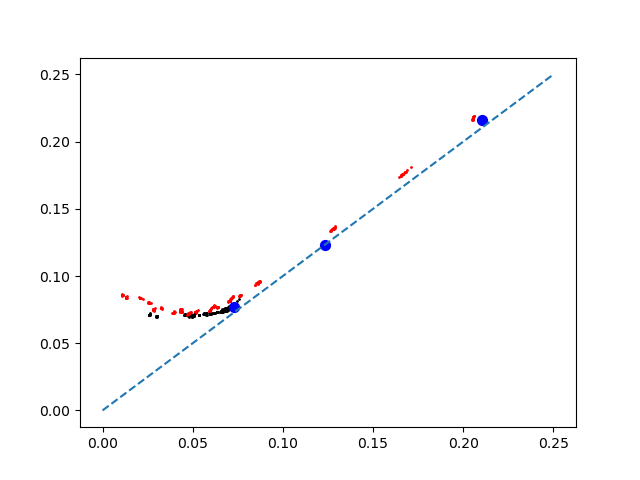

In [23]:
plt.figure()
for i,dat in enumerate(all_traintesterrors):
    (beta,gamma,latentdim,lr,savedir)=all_models[i]
    label="b%s_g%s" % (beta,gamma)
    dat = np.array(dat)
    okinds = (dat[:,1] < 0.3) * np.arange(len(dat)) > len(dat)*96/100
    train = dat[okinds,1]
    test = dat[okinds,2]
    if gamma == 0:
        plt.scatter(train,test,label=label,s=1,c="red")
    else:
        plt.scatter(train,test,label=label,s=1,c="k")
#plt.xlim(0,0.25)
#plt.ylim(0,0.25)
plt.plot([0,0.25],[0,0.25],linestyle="--")
for pcatrain, pcatest in [(0.07305331592638709, 0.07728556765359512),
                          (0.12331104565333666, 0.12333440047660903),
                         (0.21035884505403202, 0.2162807716507751)]:
    plt.scatter(pcatrain,pcatest,s=50,c="blue")
#plt.legend()
plt.savefig("FittingJustQuaternionsAllPosesTrainSize100.png")

In [19]:

plt.figure(figsize=(10,10))
for i,dat in enumerate(all_traintesterrors):
    (beta,gamma,latentdim,lr,savedir)=all_models[i]
    label="b%s_g%s" % (beta,gamma)
    dat = np.array(dat)
    okinds = (dat[:,1] < 0.3) * np.arange(len(dat)) > len(dat)*93/100
    train = dat[okinds,1]
    test = dat[okinds,2]
    if gamma != 0:
        plt.plot(np.ones_like(test) * gamma,test,label=label)
        plt.plot(np.ones_like(test) * gamma,train,label=label)
    else:
        pass#plt.plot(train,test,label=label)
plt.xscale("log")
plt.ylim(0,0.25)
for pcatrain, pcatest in [(0.08209298876189912, 0.08050582337947013),
                          (0.08209298876189912, 0.08050582337947013)]
    plt.plot([0.0001,0.1],[pcatrain,pcatrain],linestyle="--")
    plt.plot([0.0001,0.1],[pcatest,pcatest],linestyle="--")

plt.legend()

SyntaxError: invalid syntax (<ipython-input-19-ca6b2c2459cd>, line 17)